# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

import torch
import torchvision
from torchvision.datasets import CIFAR10
from torchvision.datasets.mnist import FashionMNIST
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.models import resnet18

from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from PIL import Image

import pickle
from tqdm import tqdm

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")


CPU


# Introduction

This notebook aims to reproduce a simplified version of SODA: a self-supervised denoising diffusion model proposed [in this paper](https://arxiv.org/pdf/2311.17901.pdf).

The model is made by 2 main components:


*   Encoder:
  
  It takes as input a view from the dataset and encode it in a latent vector $z$, that serves as guidance during the denoising phase.
*   Decoder/Denoiser:

  It is defined by a pair of forward and backward Markov chains, iteratively transforming a sample $x_t$ from the normal distribution into the target one and viceversa.


This model was introduced as a self-supervised diffusion model designed for representional learing. Its main goal is to represent the main features of an original view (image) into an embedding (i.e. the latent vector).

The model overview can be also seen in the following picture:


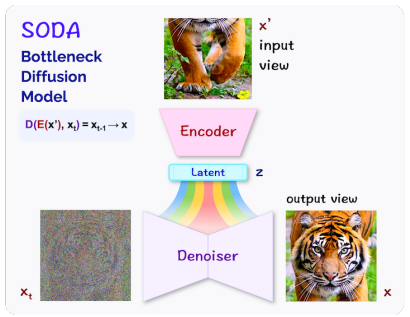



# Dataset

The paper we analyzed suggested using the ImageNet dataset for both the classification and generation tasks.

Modeling and conducting training tests for the network, however, we realized that using a dataset like ImageNet (setting a source resolution of 256x256) would have required a very complex network, which, due to computational constraints, we found impossible to create.

Therefore, we decided to opt for a dataset with smaller-sized images that still allowed us to test both the classification and generation tasks: Fashion MNIST.

Following to the specifications outlined in the paper, we performed the following preprocessing steps.


1.  Gaussian Noise Transformation: we implemented a custom class to introduce Gaussian noise to the images
2.   Transformations: the transformations vary based on the type of usage made of the images.

In particular we needed 4 different sets of images:


*   **Source** images: which are the input to the encoder
*   **Target** images: these are the same of Source images, with different transformations; these images are the input of the denoiser.
*   **Task** images: set of images needed for the downtask's training (i.e. the classification)
*   **Test** images: set of images needed for the evaluation of the downtask's results

The different kind of transformations are the following:

  *   Target : In order to strongly augment our data, we applied randomly resized crops and horizontal flips with a high probability (95%). For the same reason, we have also performed random augmentations (using RandAugment) with a probability of 65%.

  *   Source : similar to the target domain, additionally, we added Gaussian noise using our custom GaussianNoise class.
  Images are normalized.
  
  *   Task: Randomly resized crops and horizontal flips with a high probability (95%) along with normalization.

  *   Test: Images are just normalized.



















In [4]:
class GaussianNoise():
  def __init__(self, mean=0, std=0.1):
    self.mean = mean
    self.std = std

  def __call__(self, tensor):
    new_tensor = tensor + self.std * torch.randn_like(tensor) + self.mean
    return new_tensor

In [5]:
class SourceAndTarget(Dataset):
  def __init__(self, source, target):
    self.source = source
    self.target = target

  def __len__(self):
    return len(self.source)

  def __getitem__(self, idx):
    img_source = self.source.__getitem__(idx)
    img_target = self.target.__getitem__(idx)
    return img_source, img_target

In [6]:
target_transform = transforms.Compose([
    transforms.RandomApply([
        transforms.RandomResizedCrop(28),
        transforms.RandomHorizontalFlip(),
    ], p=0.95),
    transforms.RandomApply([
        transforms.RandAugment(),
    ], p=0.65),
    transforms.ToTensor(),
])

source_transform = transforms.Compose([
    target_transform,
    transforms.Normalize((0.5,), (0.5,)),
    GaussianNoise()
])

task_train_transform = transforms.Compose([
    transforms.RandomApply([
      transforms.RandomResizedCrop(28),
      transforms.RandomHorizontalFlip(),
    ], p=0.95),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

task_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

In [7]:
root = './data'
source = FashionMNIST(root=root, train=True, transform=source_transform, download=True)
target = FashionMNIST(root=root, train=True, transform=target_transform)
train_set = SourceAndTarget(source, target)

task_train = FashionMNIST(root=root, train=True, transform=task_train_transform)
task_val = FashionMNIST(root=root, train=False, transform=task_test_transform)

100%|██████████| 26421880/26421880 [00:01<00:00, 18632202.57it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 2422458.22it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 13623495.70it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 811617.69it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [8]:
train_data = DataLoader(train_set, batch_size = 64, shuffle=True)
task_train_data = DataLoader(task_train, batch_size = 64, shuffle=True)
task_test_data = DataLoader(task_val, batch_size = 64, shuffle=False)

In order to conduct a ***very*** tiny EDA, we printed a batch of images with the relative labels to better grasp what we were working on.

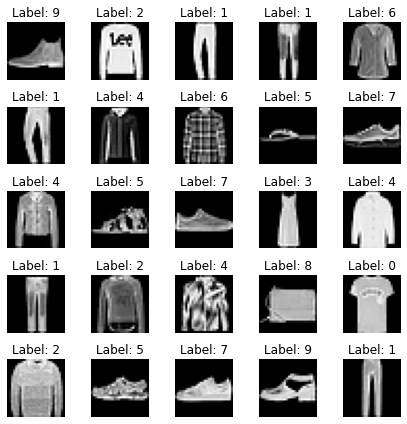

In [9]:
batch_size = 25

fig = plt.figure(figsize=(6,6))
rows = int(batch_size ** (1 / 2))
cols = round(batch_size / rows)

images, labels = next(iter(task_test_data))

i = 0
for r in range(rows):
  for c in range(cols):
    ax = fig.add_subplot(rows, cols, i + 1)
    image = images[i].numpy().squeeze()
    ax.imshow(image, cmap="gray")
    ax.set_title(f'Label: {labels[i].item()}')
    ax.axis('off')
    i += 1

plt.tight_layout()
plt.show()

# Model

## Encoder

The Encoder is used to transform an input view into a latent representation, which will guide the denoising of an output view.

The paper suggested an implementation based on a ResNet. However, ResNet takes in input 224x224 sized images, and given the dimensions of the images in our selected dataset, we believed it made more sense to use a simpler network, otherwise we would have had to fed the network with too-much-enlarged images, which would have decresed the quality.

This network is composed by 3 convolutional layers, followed by a flattening step and 2 fully connected layers to the final latent vector representing the original image.

Apart from the flatten and the last step, between each layer we called ReLU activation function.  

In [10]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(128 * 28 * 28, 256)
    self.fc2 = nn.Linear(256, 128)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = x.view(x.shape[0], -1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

## Denoiser

The denoiser features a UNet, implemented as a sequence of residual, convolutional and downsampling/upsampling layers which are linked by skip connections.

Each level of the network is realized by a series of 3 of the following block.

The block we have defined is made by a Layer Normalization, followed by two convolutional layer spaced out by GELU activation functions.

Note that in the paper the authors mentioned GELU activation function as well as a GroupNorm. However, we found that the LayerNorm gave more stable results in our specific scenario.

In [11]:
class Block(nn.Module):
  def __init__(self, shape, in_channels, out_channels, toNorm=True):
    super().__init__()
    self.toNorm = toNorm
    self.norm = nn.LayerNorm(shape)
    self.double_conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.GELU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.GELU(),
    )

  def forward(self, x):
    if self.toNorm:
      x = self.norm(x)
    h = self.double_conv(x)
    return h

Since we were interested in the realization of a denoising-diffusion model, we needed to feed the network with temporal information.

To be more specific, we had to condition the input on the current timestep, and to do so we used a sinusoidal embedding (as proposed originally in the paper) followed by a fully connected network (namely `_timeEmb`).

$\displaystyle E_i =  \left[sin\left(\frac{i}{10000^{j/dim}}\right), cos\left(\frac{i}{10000^{(j+1)/dim}}\right), … \right]$

where $i$ is the index of the step and $j$ is the index of the embedding element.  


In [16]:
def sinusoidal_embedding(n_steps, dim):
  embedding = torch.zeros(n_steps, dim)
  emb = math.log(10000)/(dim)
  emb = torch.exp(torch.arange(dim).float() * -emb)
  emb = emb.reshape((1, dim))
  t = torch.arange(n_steps).reshape((n_steps, 1))
  embedding[:,::2] = torch.sin(t * emb[:,::2])
  embedding[:,1::2] = torch.cos(t * emb[:,::2])
  return embedding.to(device)

As usual UNets, ours has an encoder-decoder structure in which the representation is downsampled 3 times, and then re-upsampled for 3 times as well.

Each down step is realized through a convolutional layer, while the up steps are made by a transposed convolution.

At each level, a residual connection appends the last representation in the encoder to the first representation (at the same level) in the decoder.

As we can see in `forward()`, the input for each level is realized by the sum of the input itself, the time embedding and the latent vector's embedding as well. This last is again computed through a fully connected network (`_zEmb`).
Again, this kind of implementation slightly simplifies the paper's one, in which the input is scaled and shifted in the following way:

$\displaystyle h=z_s\left(t_s\cdot x+t_b\right) +z_b$

where $(t_s,t_b)$ and $(z_s,z_b)$ are obtained by two different linear projections.

In [12]:
class UNet(nn.Module):
  def __init__(self, n_steps=1000, time_emb_dim=100, z_dim=128):
    super().__init__()

    # Time embedding
    self.time_embed = nn.Embedding(n_steps, time_emb_dim)
    self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
    self.time_embed.requires_grad_(False)

    # Down
    self.te1 = self._timeEmb(time_emb_dim, 1)
    self.ze1 = self._zEmb(z_dim, 1)
    self.b1 = nn.Sequential(
        Block((1, 28, 28), 1, 10),
        Block((10, 28, 28), 10, 10),
        Block((10, 28, 28), 10, 10)
    )

    self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

    self.te2 = self._timeEmb(time_emb_dim, 10)
    self.ze2 = self._zEmb(z_dim, 10)
    self.b2 = nn.Sequential(
        Block((10, 14, 14), 10, 20),
        Block((20, 14, 14), 20, 20),
        Block((20, 14, 14), 20, 20)
    )

    self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

    self.te3 = self._timeEmb(time_emb_dim, 20)
    self.ze3 = self._zEmb(z_dim, 20)
    self.b3 = nn.Sequential(
        Block((20, 7, 7), 20, 40),
        Block((40, 7, 7), 40, 40),
        Block((40, 7, 7), 40, 40)
    )

    self.down3 = nn.Sequential(
        nn.Conv2d(40, 40, 2, 1),
        nn.GELU(),
        nn.Conv2d(40, 40, 4, 2, 1)
    )

    # Middle
    self.te_mid = self._timeEmb(time_emb_dim, 40)
    self.ze_mid = self._zEmb(z_dim, 40)
    self.b_mid = nn.Sequential(
        Block((40, 3, 3), 40, 20),
        Block((20, 3, 3), 20, 20),
        Block((20, 3, 3), 20, 40)
    )

    # Up
    self.up1 = nn.Sequential(
        nn.ConvTranspose2d(40, 40, 4, 2, 1),
        nn.GELU(),
        nn.ConvTranspose2d(40, 40, 2, 1)
    )

    self.te4 = self._timeEmb(time_emb_dim, 80)
    self.ze4 = self._zEmb(z_dim, 80)
    self.b4 = nn.Sequential(
        Block((80, 7, 7), 80, 40),
        Block((40, 7, 7), 40, 20),
        Block((20, 7, 7), 20, 20)
    )

    self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)

    self.te5 = self._timeEmb(time_emb_dim, 40)
    self.ze5 = self._zEmb(z_dim, 40)
    self.b5 = nn.Sequential(
        Block((40, 14, 14), 40, 20),
        Block((20, 14, 14), 20, 10),
        Block((10, 14, 14), 10, 10)
    )

    self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)

    self.te_out = self._timeEmb(time_emb_dim, 20)
    self.ze_out = self._zEmb(z_dim, 20)
    self.b_out = nn.Sequential(
        Block((20, 28, 28), 20, 10),
        Block((10, 28, 28), 10, 10),
        Block((10, 28, 28), 10, 10, False)
    )

    self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)


  def _timeEmb(self, dim_in, dim_out):
    return nn.Sequential(
        nn.Linear(dim_in, dim_out),
        nn.GELU(),
        nn.Linear(dim_out, dim_out)
    )

  def _zEmb(self, dim_in, dim_out):
    return nn.Sequential(
        nn.Linear(dim_in, dim_out),
        nn.GELU(),
        nn.Linear(dim_out, dim_out)
    )

  def forward(self, x, t, z):
    t = self.time_embed(t)
    n = len(x)

    # Down
    out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1) + self.ze1(z).reshape(n, -1, 1, 1))
    out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1) + self.ze2(z).reshape(n, -1, 1, 1))
    out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1) + self.ze3(z).reshape(n, -1, 1, 1))

    # Middle
    out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1) + self.ze_mid(z).reshape(n, -1, 1, 1))

    # Up
    out4 = torch.cat((out3, self.up1(out_mid)), dim=1)
    out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1) + self.ze4(z).reshape(n, -1, 1, 1))
    out5 = torch.cat((out2, self.up2(out4)), dim=1)
    out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1) + self.ze5(z).reshape(n, -1, 1, 1))
    out = torch.cat((out1, self.up3(out5)), dim=1)
    out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1) + self.ze_out(z).reshape(n, -1, 1, 1))
    out = self.conv_out(out)

    return out


## SODA

SODA was born as a classical denoising diffusion model, defined by a pair of forward and backward Markov chains.

In each forward step $t$, a low Gaussian noise $ϵ_t$ is added to the input view $x_t$ according to a fixed variance schedule $α_t$.

In practice, the variance schedule is defined as a vector of size `steps` whose elements spans linearly in the range of $[1-0.001 , 1-0.02]$.

Starting from that we computed $x_t$ as:

$\displaystyle x_t = \sqrt{\bar{α_t}}\ x_{t-1} + \sqrt{(1-\bar{α_t})ϵ}$

where $\displaystyle \bar{α_t}=∏_{s = 1 }^{t}α_s$

Meanwhile, the respective backward step performs image denoising, trying to estimate $ϵ_t$ in order to recover $x_{t-1}$ from the successor $x_t$, also thanks to the conditioning given by latent vector $z$ which serves as guidance source for denoising the image.

In practice this is done by calling the UNet decoder.

In [13]:
class SODA(nn.Module):
  def __init__(self, encoder, decoder, steps):
    super(SODA, self).__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.T_max = steps
    self.schedule_x, self.schedule_noise, self.alphas = self._schedule()

  def _schedule(self):
    alphas = torch.linspace(0.0001, 0.02, self.T_max)
    alphas = 1 - alphas
    alphas_bar = torch.cumsum(torch.log(alphas), dim=0).exp()
    sqrt_alphas_bar = torch.sqrt(alphas_bar)
    alphas_bar_inv = torch.sqrt(1 - alphas_bar)
    return sqrt_alphas_bar, alphas_bar_inv, alphas

  def _add_noise(self, x, t):
    noise = torch.randn_like(x)
    x = x.to('cpu')
    noise = noise.to('cpu')
    t1 = t.to('cpu')
    x_noised = self.schedule_x[t1, None, None, None] * x + self.schedule_noise[t1, None, None, None] * noise
    return x_noised.to(device), noise.to(device)

  def _normalize_to_neg_one_to_one(self,img):
    return img * 2 - 1

  def forward(self, x_source, x_target, t):
    z = self.encoder(x_source)
    x_traget = self._normalize_to_neg_one_to_one(x_target)
    x_noised, noise = self._add_noise(x_target, t)
    res = self.decoder(x_noised, t, z)

    return noise, res



## Classifier

In order to perform the evaluation of our self-supervised model, we exploited a classifier.

This is made of a normalization layer as well as a fully connected layer.

It takes as input the latent vector $z$ of the images in the chosen dataset, and aims to classify over the 10 classes we have seen earlier.

In [14]:
class Classifier(nn.Module):
  def __init__(self, z_size, num_classes):
    super().__init__()
    self.layer1 = nn.Linear(z_size, num_classes)
    self.batch_norm = nn.BatchNorm1d(z_size, affine=False)

  def forward(self, z):
    z = self.batch_norm(z)
    z = self.layer1(z)
    return z

# Train

The training is divided into two steps. Firstly, we have trained the SODA model for 10 epochs by using:


*   the Mean Squared Error Loss, as objective function that compares the applied noise and the predicted one.
*   AdamW as the optimizer of both the encoder and the denoiser of SODA, with two different learning rates computed empirically, i.e. $2 \cdot 10^{-4}$ for the encoder and $10^{-4}$ for the decoder, by mantaining the ratio $\frac{lr_e}{lr_d}>1$.

Both of these choices were made following the specifications reported on the paper.

After that, we have proceeded in training the classifier for 15 epochs, by exploiting:


*   the Cross Entropy Loss between the predicted class and the real label, as objective function.
*   Adam as the optimizer, with a learning rate equal to $10^{-4}$.

Moreover, we have set the weight decay equal to $0.005$ empirically, for all the optimizer.



In [17]:
denoiser = UNet().to(device)
encoder = Encoder().to(device)
soda = SODA(encoder, denoiser, 200)
model = Classifier(128, 10).to(device)

### Load checkpoint

In [27]:
path = './Checkpoints/soda.pth'

checkpoint = torch.load(path, map_location=torch.device(device))
soda.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [28]:
path = './Checkpoints/classifier.pth'

checkpoint = torch.load(path, map_location=torch.device(device))
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### Training

In [18]:
def train_soda(num_epochs, criterion, optimizer_enc, optimizer_dec):
  losses = []

  for epoch in range(1,num_epochs+1):
    print(f'Epoch {epoch}:')
    running_loss = 0.0

    for source, target in tqdm(train_data):
      optimizer_enc.zero_grad()
      optimizer_dec.zero_grad()
      soda.train()

      # ignoring the labels
      x_source = source[0]
      x_target = target[0]
      x_source = x_source.to(device)
      x_target = x_target.to(device)

      t = torch.randint(0, soda.T_max, (x_target.shape[0],)).to(device)

      noise, denoise = soda(x_source, x_target, t)
      loss = criterion(noise, denoise)

      running_loss += loss.item()

      loss.backward()
      optimizer_enc.step()
      optimizer_dec.step()

    avg_loss = running_loss/len(train_data)
    losses.append(avg_loss)

    print(f'\nTrain loss {avg_loss:.3f}\n')

    checkpoint = {
      'epoch': epoch,
      'model_state_dict': soda.state_dict(),
      'optimizer_enc': optimizer_enc.state_dict(),
      'optimizer_dec': optimizer_dec.state_dict(),
      'loss': avg_loss,
    }
    checkpoint_path = f'./Checkpoints/soda{epoch}.pth'
    torch.save(checkpoint, checkpoint_path)

  return losses

In [19]:
def evaluation(num_epochs, criterion, optimizer):
  accuracies = []
  losses = []

  for epoch in range(1,num_epochs+1):
    print(f'Epoch {epoch}:')

    # Training classifier
    preds = []
    labels = []
    tot_loss_task = 0.0
    for img, label in tqdm(task_train_data):
      optimizer.zero_grad()
      soda.eval()
      model.train()
      img = img.to(device)
      label = label.to(device)

      z = soda.encoder(img)
      pred = model(z)
      loss_task = criterion(pred, label)
      loss_task.backward()
      optimizer.step()

      pred = pred.argmax(dim=-1)
      preds.append(pred)
      labels.append(label)

      tot_loss_task += loss_task.item()

    avg_loss2 = tot_loss_task/len(task_train_data)
    losses.append(avg_loss2)

    print(f'\nEvaluation loss {avg_loss2:.3f}')
    pred = torch.cat(preds)
    label = torch.cat(labels)
    acc = (pred == label).sum().item() / len(label)
    print(f"Train Accuracy: {acc:.3f}\n\n")

    checkpoint_task = {
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': avg_loss2,
    }
    checkpoint_path_task = f'./Checkpoints/classifier{epoch}.pth'
    torch.save(checkpoint_task, checkpoint_path_task)

    # Testing classifier
    preds = []
    labels = []

    batch_id = 0
    for img, label in tqdm(task_test_data):
      model.eval()
      soda.eval()
      img = img.to(device)
      label = label.to(device)
      z = soda.encoder(img)
      logit = model(z)
      pred = logit.argmax(dim=-1)
      preds.append(pred)
      labels.append(label)

    pred = torch.cat(preds)
    label = torch.cat(labels)
    acc = (pred == label).sum().item() / len(label)
    print(f"\nTest Accuracy: {acc:.3f}\n\n")
    accuracies.append(acc)
    print()

  return losses, accuracies


In [20]:
criterion = nn.MSELoss()
lr = 1.0e-4
optimizer_enc = torch.optim.AdamW(soda.encoder.parameters(), lr=lr*2, weight_decay = 0.05)
optimizer_dec = torch.optim.AdamW(soda.decoder.parameters(), lr=lr, weight_decay = 0.05)

criterion_task = nn.CrossEntropyLoss()
optimizer_task = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay = 0.05)

In [ ]:
losses = train_soda(10, criterion, optimizer_enc, optimizer_dec)

Epoch 1:


100%|██████████| 938/938 [02:40<00:00,  5.84it/s]



Train loss 0.323

Epoch 2:


100%|██████████| 938/938 [02:57<00:00,  5.28it/s]



Train loss 0.108

Epoch 3:


100%|██████████| 938/938 [02:39<00:00,  5.88it/s]



Train loss 0.093

Epoch 4:


100%|██████████| 938/938 [02:33<00:00,  6.11it/s]



Train loss 0.085

Epoch 5:


100%|██████████| 938/938 [03:14<00:00,  4.83it/s]



Train loss 0.080

Epoch 6:


100%|██████████| 938/938 [03:06<00:00,  5.02it/s]



Train loss 0.077

Epoch 7:


100%|██████████| 938/938 [03:25<00:00,  4.56it/s]



Train loss 0.075

Epoch 8:


100%|██████████| 938/938 [03:22<00:00,  4.63it/s]



Train loss 0.072

Epoch 9:


100%|██████████| 938/938 [03:16<00:00,  4.78it/s]



Train loss 0.071

Epoch 10:


100%|██████████| 938/938 [02:40<00:00,  5.83it/s]



Train loss 0.069



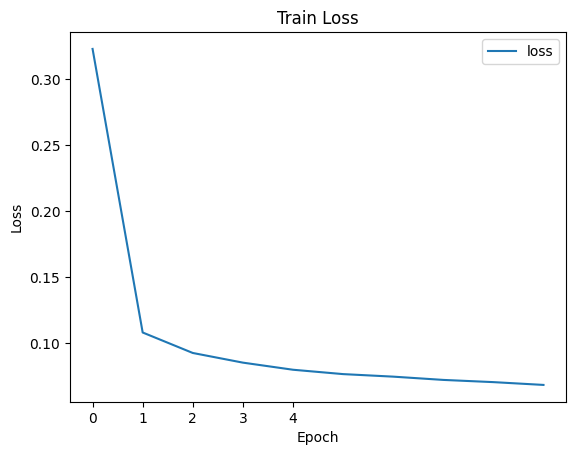

In [ ]:
plt.plot(losses, label='loss')
plt.xticks(range(5))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.legend()
plt.show()

In [ ]:
losses2, accuracies = evaluation(15, criterion_task, optimizer_task)

Epoch 1:


100%|██████████| 938/938 [00:53<00:00, 17.65it/s]



Evaluation loss 1.616
Train Accuracy: 0.435




100%|██████████| 157/157 [00:03<00:00, 44.13it/s]



Test Accuracy: 0.658



Epoch 2:


100%|██████████| 938/938 [00:53<00:00, 17.62it/s]



Evaluation loss 1.267
Train Accuracy: 0.557




100%|██████████| 157/157 [00:03<00:00, 44.00it/s]



Test Accuracy: 0.684



Epoch 3:


100%|██████████| 938/938 [00:52<00:00, 17.91it/s]



Evaluation loss 1.212
Train Accuracy: 0.571




100%|██████████| 157/157 [00:02<00:00, 54.51it/s]



Test Accuracy: 0.695



Epoch 4:


100%|██████████| 938/938 [00:53<00:00, 17.54it/s]



Evaluation loss 1.190
Train Accuracy: 0.577




100%|██████████| 157/157 [00:02<00:00, 53.15it/s]



Test Accuracy: 0.703



Epoch 5:


100%|██████████| 938/938 [00:53<00:00, 17.55it/s]



Evaluation loss 1.178
Train Accuracy: 0.580




100%|██████████| 157/157 [00:02<00:00, 53.95it/s]



Test Accuracy: 0.705



Epoch 6:


100%|██████████| 938/938 [00:52<00:00, 17.79it/s]



Evaluation loss 1.174
Train Accuracy: 0.584




100%|██████████| 157/157 [00:03<00:00, 40.87it/s]



Test Accuracy: 0.705



Epoch 7:


100%|██████████| 938/938 [00:53<00:00, 17.41it/s]



Evaluation loss 1.168
Train Accuracy: 0.585




100%|██████████| 157/157 [00:02<00:00, 53.15it/s]



Test Accuracy: 0.705



Epoch 8:


100%|██████████| 938/938 [00:53<00:00, 17.44it/s]



Evaluation loss 1.166
Train Accuracy: 0.583




100%|██████████| 157/157 [00:02<00:00, 53.61it/s]



Test Accuracy: 0.708



Epoch 9:


100%|██████████| 938/938 [00:53<00:00, 17.66it/s]



Evaluation loss 1.170
Train Accuracy: 0.581




100%|██████████| 157/157 [00:03<00:00, 39.27it/s]



Test Accuracy: 0.710



Epoch 10:


100%|██████████| 938/938 [00:53<00:00, 17.43it/s]



Evaluation loss 1.166
Train Accuracy: 0.585




100%|██████████| 157/157 [00:02<00:00, 53.60it/s]



Test Accuracy: 0.710



Epoch 11:


100%|██████████| 938/938 [00:53<00:00, 17.38it/s]



Evaluation loss 1.164
Train Accuracy: 0.583




100%|██████████| 157/157 [00:02<00:00, 53.17it/s]



Test Accuracy: 0.711



Epoch 12:


100%|██████████| 938/938 [00:53<00:00, 17.61it/s]



Evaluation loss 1.168
Train Accuracy: 0.582




100%|██████████| 157/157 [00:03<00:00, 52.25it/s]



Test Accuracy: 0.709



Epoch 13:


100%|██████████| 938/938 [00:54<00:00, 17.37it/s]



Evaluation loss 1.162
Train Accuracy: 0.583




100%|██████████| 157/157 [00:04<00:00, 38.81it/s]



Test Accuracy: 0.715



Epoch 14:


100%|██████████| 938/938 [00:54<00:00, 17.30it/s]



Evaluation loss 1.162
Train Accuracy: 0.586




100%|██████████| 157/157 [00:02<00:00, 52.85it/s]



Test Accuracy: 0.712



Epoch 15:


100%|██████████| 938/938 [00:53<00:00, 17.58it/s]



Evaluation loss 1.164
Train Accuracy: 0.588




100%|██████████| 157/157 [00:08<00:00, 19.28it/s]


Test Accuracy: 0.713





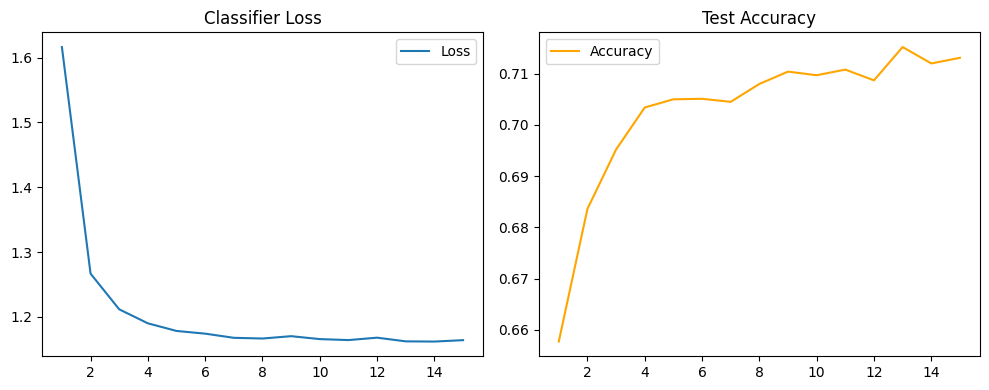

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(range(1, 16), losses2, label='Loss')
axs[0].set_title('Classifier Loss')
axs[0].legend()

axs[1].plot(range(1, 16), accuracies, label='Accuracy', color='orange')
axs[1].set_title('Test Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()

# Evaluation

## Classification

In this section we show the results of the classification over the test set.

We can see the model reaches the 71% of accuracy.

As we can see in the confusion matrix, the model perform poorly just on  class 6, but if we observe the correspondent image (at the beginning of this notebok) it is very similar to the images of classes 0,2,4, explaining the lack of performance there. This is also reflected by class 6's F1 score, precision and recall.

In [29]:
model.eval()
soda.eval()
preds = []
labels = []
for img, label in task_test_data:
  img = img.to(device)
  label = label.to(device)
  z = soda.encoder(img)
  logit = model(z)
  pred = logit.argmax(dim=-1)
  preds.append(pred)
  labels.append(label)
pred = torch.cat(preds)
label = torch.cat(labels)

In [30]:
print(classification_report(label.cpu().detach().numpy(), pred.cpu().detach().numpy()))

              precision    recall  f1-score   support

           0       0.72      0.78      0.75      1000
           1       0.94      0.94      0.94      1000
           2       0.52      0.50      0.51      1000
           3       0.62      0.80      0.70      1000
           4       0.50      0.62      0.56      1000
           5       0.85      0.86      0.86      1000
           6       0.35      0.14      0.20      1000
           7       0.74      0.89      0.81      1000
           8       0.89      0.76      0.82      1000
           9       0.88      0.84      0.86      1000

    accuracy                           0.71     10000
   macro avg       0.70      0.71      0.70     10000
weighted avg       0.70      0.71      0.70     10000



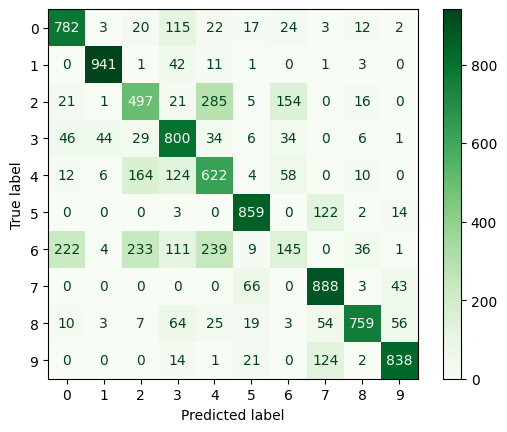

In [ ]:
ConfusionMatrixDisplay.from_predictions(label.cpu().detach().numpy(), pred.cpu().detach().numpy(), cmap = plt.cm.Greens)

## Generation

In this section we have proposed an example of generation of novel views, starting from a randomly generated tensor, which is then denoised by SODA decoder.

That represents a generic example of denoising-diffusion models' generation.

In particular, we explore each time step in reverse and we have sampled each denoised step as:

$\displaystyle x_{t-1} = \frac{1}{\sqrt{a_t}} \left(x_t - \frac{1-a_t}{\sqrt{1-\bar{a_t}}} ϵ \right)$

In [ ]:
def show_imgs(x, title=''):
  fig = plt.figure(figsize=(8, 8))
  rows = int(len(x) ** (1 / 2))
  cols = round(len(x) / rows)

  i = 0
  for r in range(rows):
    for c in range(cols):
      fig.add_subplot(rows, cols, i + 1)
      if i < len(x):
        im = x[i][10].squeeze()
        plt.imshow(im, cmap="gray")
        i += 1

  fig.suptitle(title)

  plt.show()

In [ ]:
def generate_imgs(n_samples, c=1, w=28, h=28):
  images = []

  with torch.no_grad():
    x = torch.randn(n_samples, c, h, w).to(device)

    for idx, t in enumerate(list(range(soda.T_max))[::-1]):
      time = (torch.ones(n_samples, ) * t).to(device).int()
      _, x_noised = soda(x, x, time)
      alpha_t = soda.alphas[t]
      alpha_t_bar = soda.schedule_x[t]
      x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * x_noised)

      if t % 10 == 0:
        normalized = x.clone()
        for i in range(len(normalized)):
          normalized[i] -= torch.min(normalized[i])
          normalized[i] *= 255 / torch.max(normalized[i])

        image = normalized.cpu().numpy().astype(np.uint8)
        images.append(image)

  return images

In [ ]:
g = generate_imgs(256)

As we can see in the picture below, we can see how, starting from totally random noise, we managed to obtain an almost clear representation of a boot.

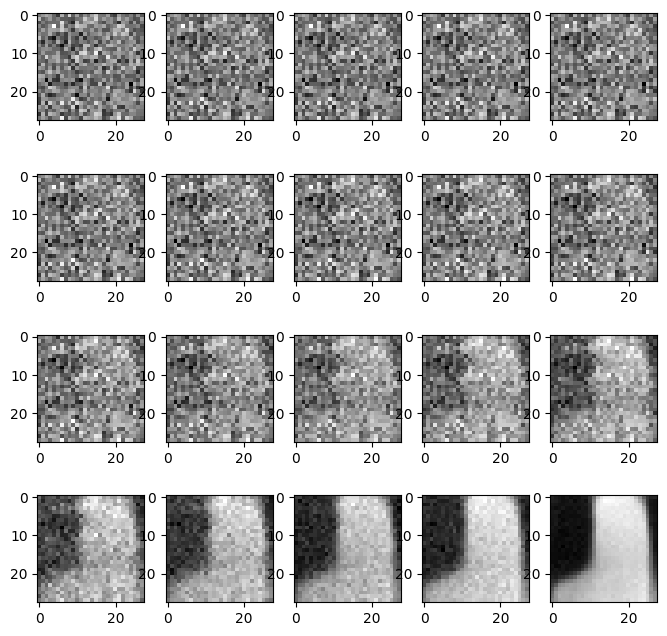

In [ ]:
show_imgs(g)